<a href="https://colab.research.google.com/github/yangjik/yang.study/blob/main/plant_pathology_2020_img_opencv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 사전 단계

In [ ]:
# 구글 드라이브 연동
from google.colab import drive
drive.mount('/content/gdrive/')

# 캐글
# !pip install kaggle

# 한글폰트
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Mounted at /content/gdrive/
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 6 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (14.7 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database

In [ ]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

#### 캐글 데이터 받기

In [ ]:
# !mkdir /root/.kaggle/
# !cp /content/gdrive/MyDrive/응용/kaggle/kaggle.json /root/.kaggle/   # kaggl.json위치 지정
# !chmod 600 /root/.kaggle/kaggle.json
# !kaggle competitions list
# !kaggle competitions download -c plant-pathology-2020-fgvc7

In [ ]:
# ls

In [ ]:
# from zipfile import ZipFile
# file_path = 'plant-pathology-2020-fgvc7.zip'

# with ZipFile(file_path, 'r') as zip:
#   zip.extractall('/content/gdrive/MyDrive/응용/kaggle/plant/data')
#   print('완료')

# Kaggle) Plant Pathology 2020 건강한 잎 / 병든 잎 이미지 분류하기

### 패키지 및 모듈 불러오기

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import random
import os, shutil
from sklearn.model_selection import train_test_split

### 데이터 구성 및 컬럼 의미 파악
- image_id: the foreign key / 외래 키
- multiple_diseases: one of the target labels / 여러 질병
- healthy: one of the target labels / 건강
- rust: one of the target labels / 녹병
- scab: one of the target labels / 붉은 곰팡이병

In [ ]:
file_path = '/content/gdrive/MyDrive/응용/kaggle/plant/data/'
train_df = pd.read_csv(file_path + 'train.csv')
test_df = pd.read_csv(file_path + 'test.csv')
train_df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [ ]:
train_df['img_file'] = train_df['image_id'] + '.jpg'

In [ ]:
train_df = train_df.replace({'multiple_diseases' : 1}, 2)
train_df = train_df.replace({'rust' : 1}, 3)
train_df = train_df.replace({'scab' : 1}, 4)

In [ ]:
# label 숫자형
train_df['label']  = train_df['healthy'] + train_df['multiple_diseases'] + train_df['rust'] + train_df['scab']

In [ ]:
# label 문자형으로 변환
label_str = []
for _ in (train_df['label']):
  if _ == 1:
    _ = str(_)
    _ = _.replace('1', 'healthy')
    label_str.append(_)
  elif _ == 2:
    _ = str(_)
    _ = _.replace('2', 'multiple_diseases')
    label_str.append(_)
  elif _ == 3:
    _ = str(_)
    _ = _.replace('3', 'rust')
    label_str.append(_)
  elif _ == 4:
    _ = str(_)
    _ = _.replace('4', 'scab')
    label_str.append(_)
label_str[:5]

# label 문자형
train_df['label_str'] = label_str

In [ ]:
train_df.head()

,image_id,healthy,multiple_diseases,rust,scab,img_file,label,label_str
0,Train_0,0,0,0,4,Train_0.jpg,4,scab
1,Train_1,0,2,0,0,Train_1.jpg,2,multiple_diseases
2,Train_2,1,0,0,0,Train_2.jpg,1,healthy
3,Train_3,0,0,3,0,Train_3.jpg,3,rust
4,Train_4,1,0,0,0,Train_4.jpg,1,healthy


In [ ]:
train_df.tail()

,image_id,healthy,multiple_diseases,rust,scab,img_file,label,label_str
1816,Train_1816,0,0,0,4,Train_1816.jpg,4,scab
1817,Train_1817,1,0,0,0,Train_1817.jpg,1,healthy
1818,Train_1818,1,0,0,0,Train_1818.jpg,1,healthy
1819,Train_1819,0,0,3,0,Train_1819.jpg,3,rust
1820,Train_1820,0,0,0,4,Train_1820.jpg,4,scab


In [ ]:
multiple_df = train_df[train_df['label_str'] == 'multiple_diseases']
multiple_df.head()

,image_id,healthy,multiple_diseases,rust,scab,img_file,label,label_str
1,Train_1,0,2,0,0,Train_1.jpg,2,multiple_diseases
6,Train_6,0,2,0,0,Train_6.jpg,2,multiple_diseases
25,Train_25,0,2,0,0,Train_25.jpg,2,multiple_diseases
36,Train_36,0,2,0,0,Train_36.jpg,2,multiple_diseases
62,Train_62,0,2,0,0,Train_62.jpg,2,multiple_diseases


In [ ]:
multiple_file_name = multiple_df.loc[:, 'img_file'].to_list()
multiple_file_name[:3]

['Train_1.jpg', 'Train_6.jpg', 'Train_25.jpg']

###  직접 이미지 만들기

In [ ]:
import os
new_dir = '/content/gdrive/MyDrive/응용/kaggle/plant/data/'
save_dir = '/content/gdrive/MyDrive/응용/kaggle/plant/data/opencv/'
opencv_dir = os.path.join(new_dir, 'opencv')
if os.path.exists(new_dir+'opencv'):
    shutil.rmtree(new_dir+'opencv')
os.mkdir(opencv_dir)

In [ ]:
import cv2

In [ ]:
def flip_img(img_path, num):
  # save_dir = '/content/gdrive/MyDrive/응용/kaggle/plant/data/opencv/'
  save_dir = '/content/gdrive/MyDrive/응용/kaggle/plant/data/train/'
  file_name = save_dir+'Train_'+num+'.jpg'
  img = cv2.imread(img_path)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_flip = cv2.flip(img_rgb, 1)   # 1 = 좌우반전, 0, 상하반전

  cv2.imwrite(file_name, img_flip)

In [ ]:
def rotation_30_img(img_path, num):
  # save_dir = '/content/gdrive/MyDrive/응용/kaggle/plant/data/opencv/'
  save_dir = '/content/gdrive/MyDrive/응용/kaggle/plant/data/train/'
  file_name = save_dir+'Train_'+num+'.jpg'
  img = cv2.imread(img_path)
  h, w, c = img.shape
  img_ro = cv2.getRotationMatrix2D((h//2, w//2), 30, 1)
  result_img = cv2.warpAffine(img, img_ro, (h, w))

  cv2.imwrite(file_name, result_img)

In [ ]:
def rotation_120_img(img_path, num):
  # save_dir = '/content/gdrive/MyDrive/응용/kaggle/plant/data/opencv/'
  save_dir = '/content/gdrive/MyDrive/응용/kaggle/plant/data/train/'
  file_name = save_dir+'Train_'+num+'.jpg'
  img = cv2.imread(img_path)
  h, w, c = img.shape
  img_ro = cv2.getRotationMatrix2D((h//2, w//2), 120, 1)
  result_img = cv2.warpAffine(img, img_ro, (h, w))

  cv2.imwrite(file_name, result_img)

In [ ]:
def blur_img(img_path, num):
  # save_dir = '/content/gdrive/MyDrive/응용/kaggle/plant/data/opencv/'
  save_dir = '/content/gdrive/MyDrive/응용/kaggle/plant/data/train/'
  file_name = save_dir+'Train_'+num+'.jpg'
  img = cv2.imread(img_path)
  img_blur = cv2.blur(img, (30, 30))

  cv2.imwrite(file_name, img_blur)

In [ ]:
dir = '/content/gdrive/MyDrive/응용/kaggle/plant/data/train/'

test_name = dir
new_num = 1821

for _ in multiple_file_name:
  test = test_name + _
  str_num = str(new_num)
  flip_img(test, str_num)
  new_num += 1

In [ ]:
dir = '/content/gdrive/MyDrive/응용/kaggle/plant/data/train/'

test_name = dir
new_num = 1912

for _ in multiple_file_name:
  test = test_name + _
  str_num = str(new_num)
  rotation_30_img(test, str_num)
  new_num += 1

In [ ]:
dir = '/content/gdrive/MyDrive/응용/kaggle/plant/data/train/'

test_name = dir
new_num = 2094

for _ in multiple_file_name:
  test = test_name + _
  str_num = str(new_num)
  rotation_120_img(test, str_num)
  new_num += 1

In [ ]:
dir = '/content/gdrive/MyDrive/응용/kaggle/plant/data/train/'

test_name = dir
new_num = 2003

for _ in multiple_file_name:
  test = test_name + _
  str_num = str(new_num)
  blur_img(test, str_num)
  new_num += 1

### 추가된 데이터 시각화 and 기존 데이터프레임 합치기

In [ ]:
train_df

,image_id,healthy,multiple_diseases,rust,scab,img_file,label,label_str
0,Train_0,0,0,0,4,Train_0.jpg,4,scab
1,Train_1,0,2,0,0,Train_1.jpg,2,multiple_diseases
2,Train_2,1,0,0,0,Train_2.jpg,1,healthy
3,Train_3,0,0,3,0,Train_3.jpg,3,rust
4,Train_4,1,0,0,0,Train_4.jpg,1,healthy
...,...,...,...,...,...,...,...,...
1816,Train_1816,0,0,0,4,Train_1816.jpg,4,scab
1817,Train_1817,1,0,0,0,Train_1817.jpg,1,healthy
1818,Train_1818,1,0,0,0,Train_1818.jpg,1,healthy
1819,Train_1819,0,0,3,0,Train_1819.jpg,3,rust


In [ ]:
path = '/content/gdrive/MyDrive/응용/kaggle/plant/data/opencv/'
name_list = os.listdir(path)

In [ ]:
len(name_list)

364

In [ ]:
id = []
for _ in name_list:
   _ = _.split('.')[0]
   id.append(_)

In [ ]:
import numpy as np
a = np.zeros(shape=(len(name_list),), dtype=np.int8)
b = np.zeros(shape=(len(name_list),), dtype=np.int8) + 2
c = np.zeros(shape=(len(name_list),), dtype=np.int8)
d = np.zeros(shape=(len(name_list),), dtype=np.int8)
e = np.zeros(shape=(len(name_list),), dtype=np.int8) + 2

In [ ]:
f = []
n = 1
while True:
  if n == 365:
    break
  else :
    f.append('multiple_diseases')
    n += 1

In [ ]:
len(f)

364

In [ ]:
new_data = {
    'image_id' : id,
    'healthy' : a,
    'multiple_diseases' : b,
    'rust' : c,
    'scab' :  d,
    'img_file' :  name_list,
    'label' :  e,
    'label_str' : f
}

In [ ]:
df = pd.DataFrame(new_data)

In [ ]:
df

,image_id,healthy,multiple_diseases,rust,scab,img_file,label,label_str
0,Train_1821,0,2,0,0,Train_1821.jpg,2,multiple_diseases
1,Train_1822,0,2,0,0,Train_1822.jpg,2,multiple_diseases
2,Train_1823,0,2,0,0,Train_1823.jpg,2,multiple_diseases
3,Train_1824,0,2,0,0,Train_1824.jpg,2,multiple_diseases
4,Train_1825,0,2,0,0,Train_1825.jpg,2,multiple_diseases
...,...,...,...,...,...,...,...,...
359,Train_2089,0,2,0,0,Train_2089.jpg,2,multiple_diseases
360,Train_2090,0,2,0,0,Train_2090.jpg,2,multiple_diseases
361,Train_2091,0,2,0,0,Train_2091.jpg,2,multiple_diseases
362,Train_2092,0,2,0,0,Train_2092.jpg,2,multiple_diseases


In [ ]:
save_csv = pd.concat((train_df, df), axis=0)

In [ ]:
save_csv.reset_index(drop=True, inplace=True)

In [ ]:
save_csv

,image_id,healthy,multiple_diseases,rust,scab,img_file,label,label_str
0,Train_0,0,0,0,4,Train_0.jpg,4,scab
1,Train_1,0,2,0,0,Train_1.jpg,2,multiple_diseases
2,Train_2,1,0,0,0,Train_2.jpg,1,healthy
3,Train_3,0,0,3,0,Train_3.jpg,3,rust
4,Train_4,1,0,0,0,Train_4.jpg,1,healthy
...,...,...,...,...,...,...,...,...
2180,Train_2089,0,2,0,0,Train_2089.jpg,2,multiple_diseases
2181,Train_2090,0,2,0,0,Train_2090.jpg,2,multiple_diseases
2182,Train_2091,0,2,0,0,Train_2091.jpg,2,multiple_diseases
2183,Train_2092,0,2,0,0,Train_2092.jpg,2,multiple_diseases


In [ ]:
save_csv['label'].value_counts()

3    622
4    592
1    516
2    455
Name: label, dtype: int64

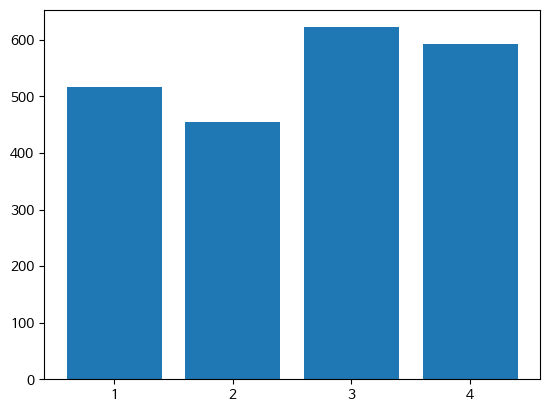

In [ ]:
plt.bar(data=save_csv['label'], x= save_csv['label'].value_counts().index, height=save_csv['label'].value_counts())

plt.xticks(save_csv['label'].value_counts().index)
plt.show()

### 완성된 데이터프레임 csv 파일로 저장

In [ ]:
save_path = '/content/gdrive/MyDrive/응용/kaggle/plant/data/'
file_name = 'new_train.csv'
save_name = save_path + file_name

save_csv.to_csv(save_name, encoding='utf-8', index=False)